# Clasificación GBC
En este notebook vamos a realizar la clasificación de los datos con el clasificador Gradient Boosting. Obtendremos algunas métricas y plots para analizar su rendimiento y compararemos la distribución de los datos reales y la obtenida con la clasificación.

## Cargamos los datos

In [1]:
# Importamos las librerias a utilizar
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, log_loss, recall_score, plot_confusion_matrix,classification_report, f1_score
from sklearn.ensemble import GradientBoostingClassifier

In [2]:
# Importamos los datos
datos = ['../data/RD_GBC_0', '../data/RD_GBC_1', '../data/RD_GBC_2', '../data/RD_GBC_3', '../data/RD_GBC_4',
        '../data/RD_GBC_5', '../data/RD_GBC_6', '../data/RD_GBC_7', '../data/RD_GBC_8', '../data/RD_GBC_9']
df = pd.DataFrame()

for path in datos:
    df_i = pd.read_csv(path)
    df = pd.concat([df, df_i])
    
df.shape

(512000, 18)

In [3]:
df.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrones_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrones_j2,m_jj,deltaR_j12,n_hadrones,label
0,1286.727685,106.912129,0.185508,-2.763676,1313.290435,0.624659,36,1283.220733,63.164215,0.064989,0.393688,1287.481934,0.713248,33,170.076344,3.159663,109.0,0.0
1,1354.394070,614.269108,0.826505,1.365524,1943.559886,0.311688,84,1325.613761,439.064150,-0.874319,-1.786248,1916.370744,0.276881,97,1053.333258,3.581406,208.0,0.0
2,1214.955723,645.865619,-0.196786,2.040545,1396.840654,0.238205,119,1072.462085,113.768840,0.143831,-1.090330,1089.530630,0.726963,59,759.634459,3.149348,196.0,0.0
3,1285.227873,516.835248,0.328693,2.975321,1450.485926,0.013429,65,1220.251279,174.796077,0.294854,-0.322661,1285.618789,0.706361,89,691.631325,3.298155,183.0,0.0
4,1210.415787,129.499352,-0.744836,-2.883347,1567.345300,0.423550,54,1091.785816,155.362262,1.060534,0.264977,1772.340209,0.787662,57,284.861613,3.629229,169.0,1.0


**Separamos la data** en un conjunto de datos de entrenamiento y un conjunto de datos de prueba:

In [4]:
# Definimos una función para separar un dataframe en caracteristicas y label

from sklearn.preprocessing import MinMaxScaler
pd.options.mode.chained_assignment = None  # default='warn'

def data_ready(df, label='label'):
    
    # Creamos una lista con las características a considerar en el modelo
    carac_cols = df.columns.values.tolist()
    
    # Eliminamos 'label' porque no es una característica
    carac_cols.remove(label)

    # Hacemos un dataframe solo con las características
    X = df[carac_cols]
    
    # Normalizamos los datos
    '''
    for column in list(X.columns):
        feature = np.array(X[column]).reshape(-1,1)
        scaler = MinMaxScaler()
        scaler.fit(feature)
        feature_scaled = scaler.transform(feature)
        X[column] = feature_scaled.reshape(1,-1)[0]
    '''
    # Obtenemos la serie con la información sobre señal o fondo
    y = df[label]
    
    return X, y

In [5]:
X, y = data_ready(df)
X_train_m, X_test_m, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1, stratify=y)

# Eliminamos las columnas de masa para que el entrenamiento sea libre de modelo
X_train = X_train_m.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
X_test = X_test_m.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)

#df.loc[X_train.index]

In [6]:
# Estandarizamos las variables
scaler = MinMaxScaler()
X_train[X_train.columns] = scaler.fit_transform(X_train[X_train.columns])
X_test[X_test.columns] = scaler.fit_transform(X_test[X_test.columns])

In [7]:
X_train.head()

,pT_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrones_j1,pT_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrones_j2,deltaR_j12,n_hadrones
13950,0.023766,0.447932,0.572749,0.026637,0.194259,0.177165,0.236204,0.319188,0.073249,0.228341,0.187415,0.170732,0.468489,0.135043
40914,0.163466,0.512338,0.824834,0.110933,0.288922,0.240157,0.329691,0.687570,0.317613,0.344764,0.245672,0.178862,0.495242,0.184615
23239,0.073016,0.411868,0.253741,0.062484,0.412827,0.244094,0.282658,0.334711,0.745132,0.259233,0.184162,0.321138,0.446029,0.249573
39807,0.014362,0.379798,0.973110,0.043124,0.493650,0.244094,0.242288,0.251246,0.438868,0.310071,0.313793,0.272358,0.524856,0.244444
21877,0.066394,0.255427,0.177565,0.216971,0.459898,0.074803,0.166781,0.368110,0.719979,0.130329,0.703020,0.186992,0.533256,0.150427


Vemos que la distribución de clases coincida en ambos conjuntos de datos

In [8]:
print('y_train class distribution')
print(y_train.value_counts(normalize=True))

print('y_test class distribution')
print(y_test.value_counts(normalize=True))

y_train class distribution
0.0    0.908714
1.0    0.091286
Name: label, dtype: float64
y_test class distribution
0.0    0.908711
1.0    0.091289
Name: label, dtype: float64


## Clasificación
Definimos el clasificador, lo entrenamos y hacemos las predicciones

In [9]:
clf = GradientBoostingClassifier()
nombre = clf.__class__.__name__

clf.fit(X_train, y_train)
y_proba = clf.predict_proba(X_test)
y_pred = clf.predict(X_test)

Obtenemos métricas de acuerdo a la clasificación:

In [10]:
print(classification_report(y_test, y_pred, target_names=['fondo','señal']))

              precision    recall  f1-score   support

       fondo       0.96      0.99      0.97    139578
       señal       0.82      0.57      0.67     14022

    accuracy                           0.95    153600
   macro avg       0.89      0.78      0.82    153600
weighted avg       0.95      0.95      0.95    153600



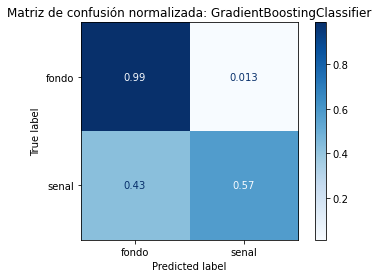

In [11]:
disp = plot_confusion_matrix(clf, X_test, y_test,
                                 display_labels=['fondo','senal'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title("Matriz de confusión normalizada: {}".format(nombre))
plt.show()

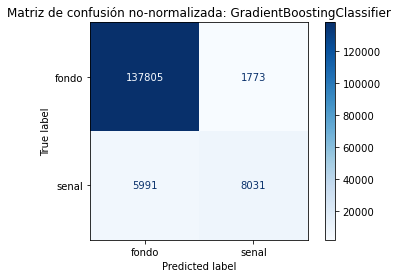

In [12]:
disp = plot_confusion_matrix(clf, X_test, y_test,
                             display_labels=['fondo','senal'],
                             cmap=plt.cm.Blues,
                             normalize=None)

disp.ax_.set_title("Matriz de confusión no-normalizada: {}".format(nombre))

plt.show()

In [13]:
precision = precision_score(y_test, y_pred)
ll = log_loss(y_test, y_proba)
f1 = f1_score(y_test, y_pred)

print("Precision: {:.2%} \n Log score: {:.4f} \n F1 score: {:.4f}".format(precision ,ll, f1))

Precision: 81.92% 
 Log score: 0.1377 
 F1 score: 0.6741


In [14]:
fi_gb = clf.feature_importances_.tolist()
peso = [ round(elem, 3) for elem in fi_gb ]
features = X_train.columns.tolist()
scores = list(zip(features, peso))
scores

[('pT_j1', 0.073),
 ('eta_j1', 0.0),
 ('phi_j1', 0.001),
 ('E_j1', 0.001),
 ('tau_21_j1', 0.231),
 ('nhadrones_j1', 0.013),
 ('pT_j2', 0.257),
 ('eta_j2', 0.0),
 ('phi_j2', 0.001),
 ('E_j2', 0.002),
 ('tau_21_j2', 0.232),
 ('nhadrones_j2', 0.009),
 ('deltaR_j12', 0.057),
 ('n_hadrones', 0.124)]

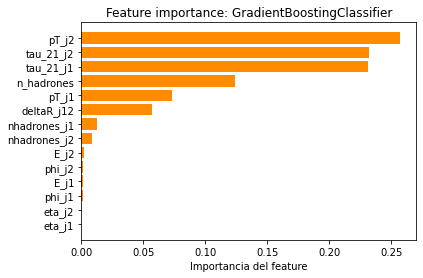

In [15]:
# Ordenamos de menor a mayor
scores.sort(key=lambda x: x[1], reverse=False) 

# Salvamos los nombres y su puntaje separados
# y revertimos las tuplas para tener de mayor a menor puntaje  
features = list(zip(*scores))[0]
score = list(zip(*scores))[1]
x_pos = np.arange(len(features)) 

# Graficamos
plt.barh(x_pos, score,align='center', color = 'darkorange')
plt.yticks(x_pos, features) 
plt.xlabel('Importancia del feature')
plt.title('Feature importance: {}'.format(nombre))
plt.show()

## ROC y AUC
Graficamos la curva ROC y obtenemos el puntaje AUC

In [16]:
def roc_curve_and_score(y_test, pred_proba):
    fpr, tpr, _ = roc_curve(y_test.ravel(), pred_proba.ravel())
    roc_auc = roc_auc_score(y_test.ravel(), pred_proba.ravel())
    return fpr, tpr, roc_auc

In [17]:
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib

fpr, tpr, roc_auc = roc_curve_and_score(y_test, y_proba[:, 1])

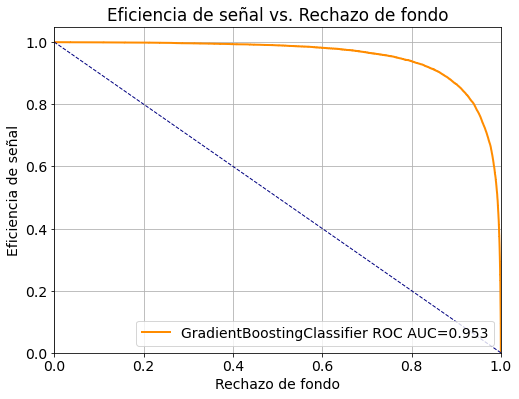

In [18]:
plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

plt.plot(1-fpr, tpr, color='darkorange', lw=2,
         label='{} ROC AUC={:.3f}'.format(nombre, roc_auc))


plt.plot([1, 0], [0, 1], color='navy', lw=1, linestyle='--')
plt.legend(loc="lower right")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Rechazo de fondo')
plt.ylabel('Eficiencia de señal')
plt.title('Eficiencia de señal vs. Rechazo de fondo')
plt.show()

Graficamos otro tipo de ROC

<ipython-input-19-19eb22cb2463>:5: RuntimeWarning: divide by zero encountered in true_divide
  plt.plot(tpr, 1/fpr, color='darkorange', lw=2,


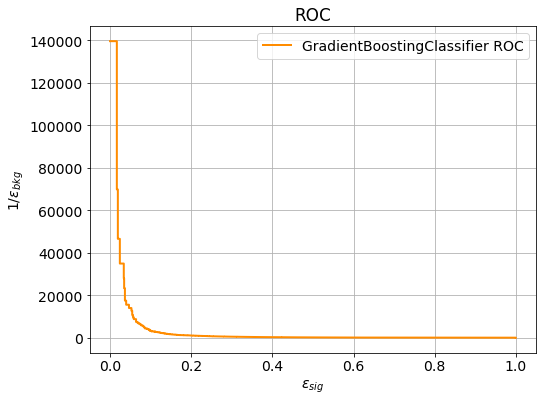

In [19]:
plt.figure(figsize=(8, 6))
matplotlib.rcParams.update({'font.size': 14})
plt.grid()

plt.plot(tpr, 1/fpr, color='darkorange', lw=2,
         label='{} ROC'.format(nombre))


plt.legend(loc="upper right")
plt.xlabel('$\epsilon_{sig}$')
plt.ylabel('$1/\epsilon_{bkg}$')
plt.title('ROC')
plt.show()

## Distribuciones
Hacemos plots de las distribuciones **después de la clasificación**

In [20]:
def plot_comp(df, variable, n_bins=50, log=False, label='label'):
    
    pred_fondo = df[df['y_pred'] == 0]
    pred_sig = df[df['y_pred'] == 1]

    fondo = df[df[label] == 0]
    sig = df[df[label] == 1]
    
    fondopred = pred_fondo[variable]
    senalpred = pred_sig[variable]

    fondo = fondo[variable]
    senal = sig[variable]
    
    
    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1)
    titulo = 'Distribución de {}'.format(variable)
    
    # Hacemos los histogramas
    fondopred.plot.hist(bins=n_bins, histtype='step', log=log, color='green', label='fondo pred', density=True)
    senalpred.plot.hist(bins=n_bins, histtype='step', log=log, color='orange', label='señal pred', density=True)

    fondo.plot.hist(bins=n_bins, log=log, facecolor='blue', alpha=0.2, label='fondo', density=True)
    senal.plot.hist(bins=n_bins, log=log, facecolor='red', alpha=0.2, label='señal', density=True)

    # Agregamos información al gráfico
    plt.xlabel(variable)
    plt.ylabel('Densidad de eventos')
    plt.legend(loc='upper right')
    plt.title(titulo)
    
    return plt.show()

In [21]:
df_test = df.iloc[y_test.index].copy()

X_test_m['y_pred'] = y_pred
X_test_m['label'] = y_test

X_test_m.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrones_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrones_j2,m_jj,deltaR_j12,n_hadrones,y_pred,label
7704,1245.335366,589.122521,-0.591652,2.566940,1583.408925,0.252553,100,1113.805169,61.245864,0.801365,-0.797360,1492.250629,0.301229,31,650.368385,3.641292,191.0,0.0,0.0
13843,1490.167755,123.532076,0.163960,0.372214,1515.286474,0.709907,39,1419.495073,60.903034,0.001545,-2.751416,1420.802678,0.440108,27,184.435110,3.127850,109.0,0.0,0.0
44955,1436.961210,101.657847,-0.488022,0.427252,1614.704990,0.620576,31,1061.226122,282.394158,0.430838,-2.555102,1195.095384,0.343264,88,384.052005,3.120696,195.0,0.0,0.0
6850,1261.358720,218.808374,1.172695,1.354259,2243.439433,0.726776,51,1201.313206,287.944492,-1.255317,-1.732465,2296.971844,0.347862,112,506.752866,3.927227,234.0,0.0,0.0
44215,1300.249334,232.676144,0.123892,2.329810,1330.740280,0.933545,64,1224.618066,150.389562,-0.065651,-0.714245,1236.438223,0.409710,42,383.065706,3.049950,183.0,0.0,0.0


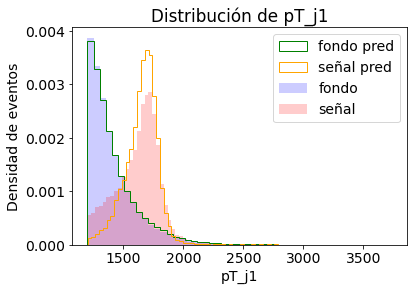

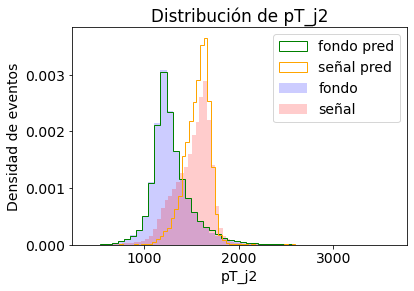

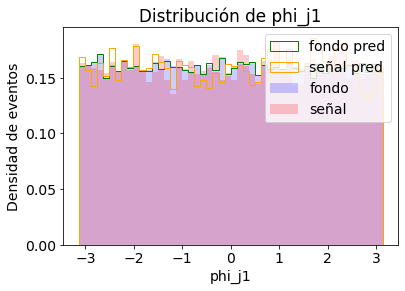

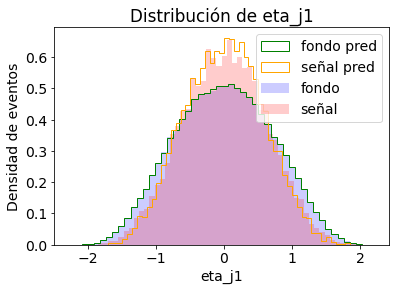

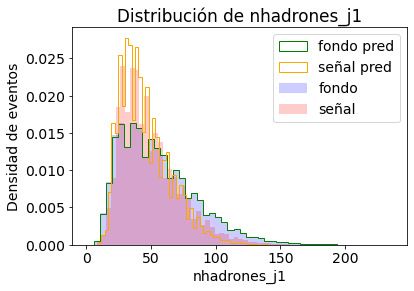

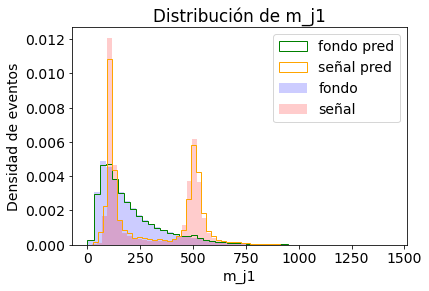

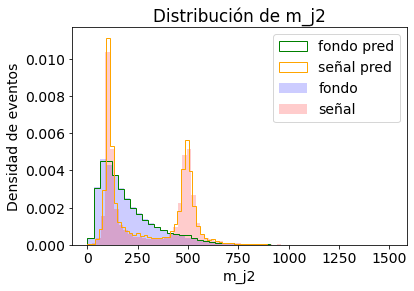

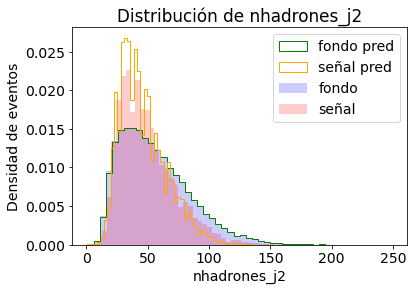

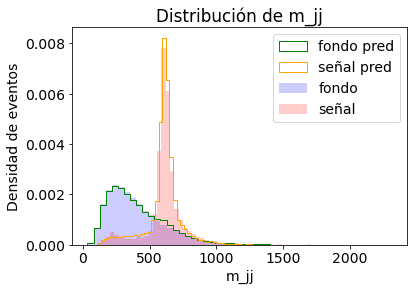

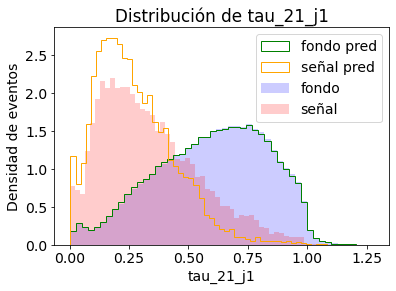

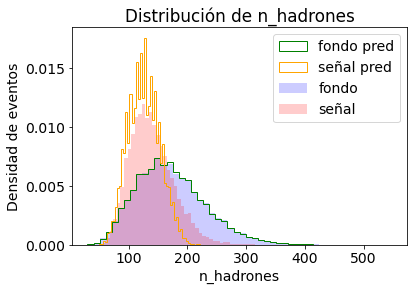

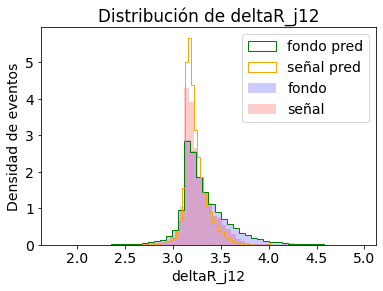

In [22]:
lista = ['pT_j1', 'pT_j2', 'phi_j1', 'eta_j1', 'nhadrones_j1',  
         'm_j1', 'm_j2', 'nhadrones_j2', 'm_jj','tau_21_j1', 
         'n_hadrones', 'deltaR_j12']

for variable in lista:
        plot_comp(X_test_m, variable)

# Clasificación BB1
Ahora que entrenamos el algoritmos, podemos utilizar los datos de la BB1 para hacer la clasificación y estudiar lo obtenido

In [23]:
# Importamos los datos
datos = ['../data/datosBB1_0', '../data/datosBB1_1', '../data/datosBB1_2', '../data/datosBB1_3', '../data/datosBB1_4',
        '../data/datosBB1_5', '../data/datosBB1_6', '../data/datosBB1_7', '../data/datosBB1_8', '../data/datosBB1_9']
df_bb = pd.DataFrame()

for path in datos:
    df_i = pd.read_csv(path)
    df_bb = pd.concat([df_bb, df_i])
    
df_bb.shape

(512000, 18)

In [24]:
# Separamos los datos
X_bb_m, y_label = data_ready(df_bb)

# Eliminamos las columnas de masa para que el entrenamiento sea libre de modelo
X_bb = X_bb_m.drop(['m_j1', 'm_j2', 'm_jj'], axis=1)
# Estandarizamos las variables
X_bb[X_bb.columns] = scaler.fit_transform(X_bb[X_bb.columns])

In [25]:
# Hacemos la prediccion
y_pred_bb = clf.predict(X_bb)

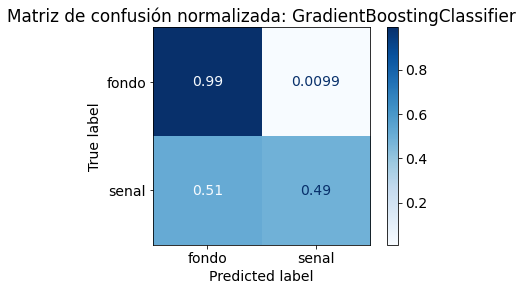

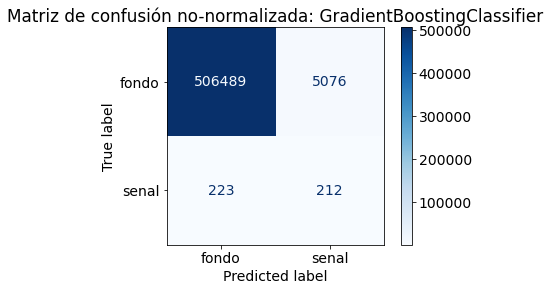

In [26]:
disp = plot_confusion_matrix(clf, X_bb, y_label,
                                 display_labels=['fondo','senal'],
                                 cmap=plt.cm.Blues,
                                 normalize='true')
disp.ax_.set_title("Matriz de confusión normalizada: {}".format(nombre))
plt.show()

disp = plot_confusion_matrix(clf, X_bb, y_label,
                             display_labels=['fondo','senal'],
                             cmap=plt.cm.Blues,
                             normalize=None)

disp.ax_.set_title("Matriz de confusión no-normalizada: {}".format(nombre))

plt.show()

In [27]:
X_bb_m['label'] = y_label
X_bb_m['y_pred'] = y_pred_bb

X_bb_m.head()

,pT_j1,m_j1,eta_j1,phi_j1,E_j1,tau_21_j1,nhadrones_j1,pT_j2,m_j2,eta_j2,phi_j2,E_j2,tau_21_j2,nhadrones_j2,m_jj,deltaR_j12,n_hadrones,label,y_pred
0,1397.005228,170.225610,-0.765391,0.537239,1834.490410,0.543602,70,1347.988973,427.365520,0.225140,-2.740281,1446.853969,0.880080,82,597.591130,3.423930,230.0,0.0,0.0
1,1273.332773,327.845663,0.354693,-0.951367,1393.391014,0.403889,77,1034.297905,106.489303,-0.364250,2.119474,1108.799742,0.927609,44,434.334966,3.153878,156.0,0.0,0.0
2,1268.472197,72.622808,-1.055852,-0.319414,2045.001255,0.685529,21,1133.216562,456.691841,0.738184,2.727534,1526.179769,0.073868,54,529.314649,3.535882,134.0,0.0,0.0
3,1414.022037,208.706758,-0.428495,2.622507,1559.858883,0.405329,81,1364.308129,60.057918,-0.242186,-0.992484,1405.798737,0.638481,39,268.764676,3.619790,247.0,0.0,0.0
4,1220.274012,170.788218,-0.076185,-1.373332,1235.676617,0.466025,38,1210.723592,402.915624,-0.275398,1.633799,1319.927141,0.097154,34,573.703842,3.013722,148.0,0.0,0.0


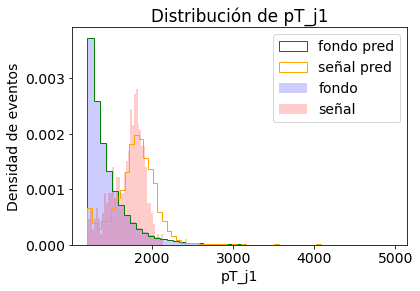

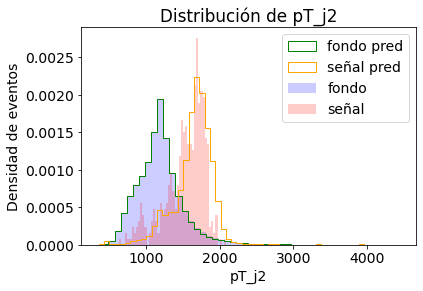

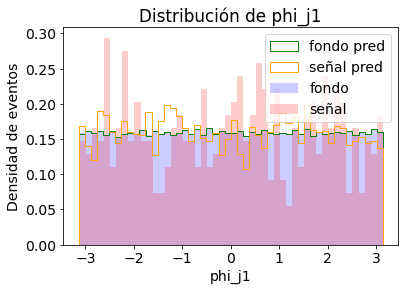

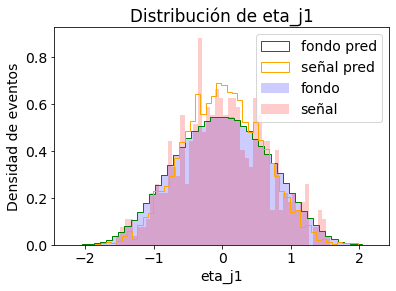

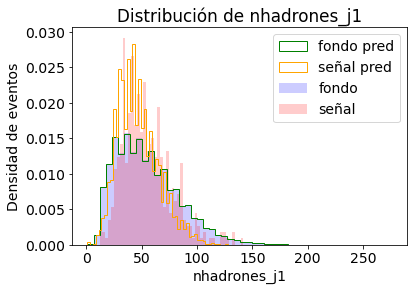

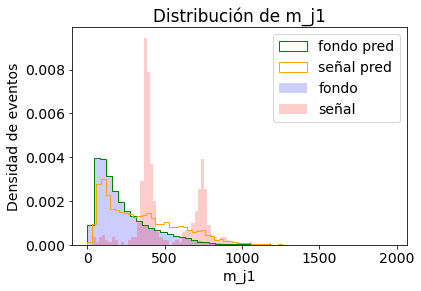

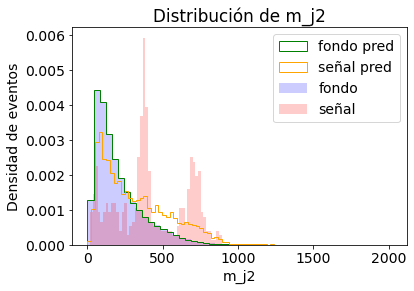

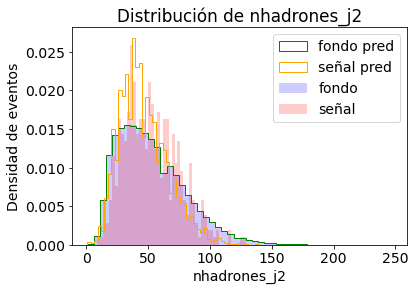

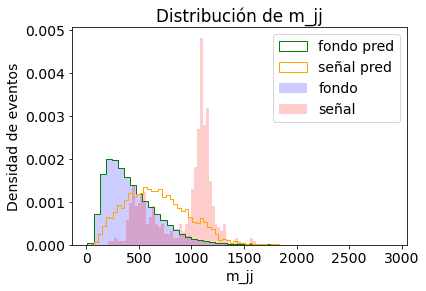

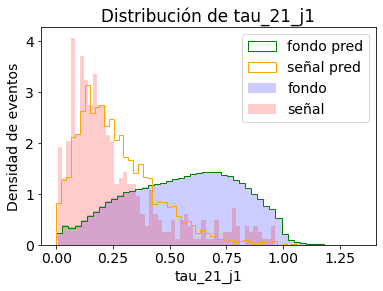

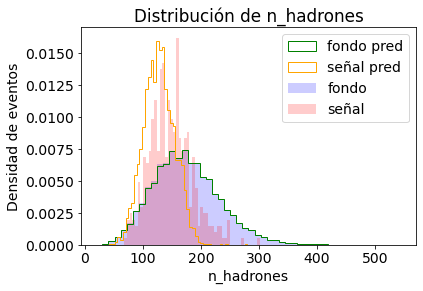

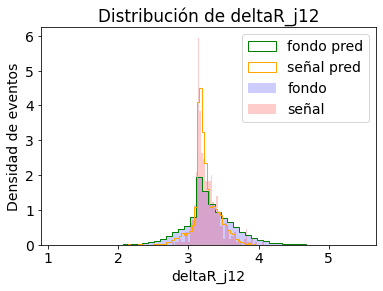

In [28]:
lista = ['pT_j1', 'pT_j2', 'phi_j1', 'eta_j1', 'nhadrones_j1',  
         'm_j1', 'm_j2', 'nhadrones_j2', 'm_jj','tau_21_j1', 
         'n_hadrones', 'deltaR_j12']

for variable in lista:
        plot_comp(X_bb_m, variable)